In [5]:
import mxnet as mx
from mxnet import nd
# Import Neural Network
from mxnet.gluon import nn

import matplotlib.pyplot as plt

Most of the neural network architectures used in computer vision share a set of common building blocks. These include compositional layers, fully connected layers and putting layers.
In gluon, the base unit of neural network operation is called a block, a block takes in one or more inputs and returns one or more outputs.

- A block can have learnable of fixed parameters.
- Blocks can also be composed, and the composition of one or more blocks is still a block.
- The role of a block is to manipulate data flowing through the network and hold onto parameters if necessary.

In [3]:
# Create a convolutional layer in Gluon
layer = nn.Conv2D(
    channels=1, #specifies how many output channels. How many different convolutional masks will be applied in parallel to the same input.
    kernel_size=(3,3), # It defines how big the convolutional kernel is. (3,3) is the most common
    in_channels=1,
    strides=(1,1), # How many cells should the kernel move between patches
    padding=(0,0), # It defines how many zeros to be added around the input.
    activation='relu', # This is the activation to apply after the convoluton. 'relu' is Rectified Linear Units activation.
    prefix='conv_'
)
layer

Conv2D(1 -> 1, kernel_size=(3, 3), stride=(1, 1), Activation(relu))

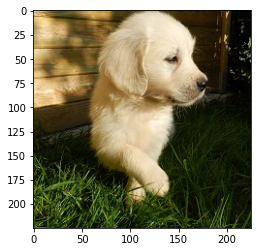

In [8]:
# Load Image
o = plt.imshow(plt.imread('./dog3.jpg'))

In [9]:
# Initialize a convolutional layout parameters to fixed values.
layer.initialize(mx.init.Constant([
    [-1,0,1], # Sobel Operator
    [-2,0,2], # Detect Vertical lines
    [-1,0,1]
]))

Sobel Operator is hand engineered kernel with specific values that detect vertical and horizontal edges.

$$\text{sobel}_\text{vertical} = \begin{bmatrix}  -1 & 0 & 1 \\ -2 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix} $$
$$\text{sobel}_\text{horizontal} = \begin{bmatrix}  -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix} $$

In deeplearning, the values of the weights are set automatically through backward propagation. But since we are not training a network so, it is added manually 

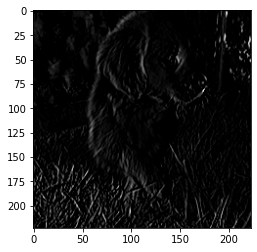

In [10]:
# Since there a single input channel, let's set the image to grayscale amd convert it to float 32 representation.
image = mx.image.imread('./dog3.jpg',0).astype('float32')
# Convert it to be channel first instead of channel last. From HWC to CHW
image_channel_first = image.transpose((2,0,1))
# Convert this 3D NDArray to a 4 NDArray with a dummy first channel. So to be batch, channel, height, weight (NCHW) format
image_batchified = image_channel_first.expand_dims(axis = 0)
# Pass the image through the ConV2D layers that was initialized with custom weights.
output = layer(image_batchified)
# Plot the resulting image.
o = plt.imshow(output.squeeze().asnumpy(), cmap = 'gray')

## Parameters
A deeper look at the inner workings of this convolutional layer.
- Each block in gluon can have zero or more parameters.
- They are collected recursively from children blocks, if necessary.

In [16]:
# Check for parameters in layer
layer.collect_params()

conv_ (
  Parameter conv_weight (shape=(1, 1, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter conv_bias (shape=(1,), dtype=<class 'numpy.float32'>)
)

In [17]:
# Parameters can be accessed directly
layer.collect_params()['conv_weight']

Parameter conv_weight (shape=(1, 1, 3, 3), dtype=<class 'numpy.float32'>)

In [18]:
# Or with shortcut
layer.weight

Parameter conv_weight (shape=(1, 1, 3, 3), dtype=<class 'numpy.float32'>)

In [19]:
# The values of the weights can be accessed directly using data()
layer.weight.data()


[[[[-1.  0.  1.]
   [-2.  0.  2.]
   [-1.  0.  1.]]]]
<NDArray 1x1x3x3 @cpu(0)>

In [20]:
 # Or the bias, that is initialized by 0 by default
 layer.bias.data()


[0.]
<NDArray 1 @cpu(0)>

### Max Pooling
- It is the Next Building Block.
- It is an operatoon that reduces a spatial resolution of feature map, while conserving the highest activations.
- Feature map is any of the intermediate feature implementation generated as we go through the network.
- It is working by sliding the pooling window by keeping only the highest activation in each window.

In [21]:
# Create a poolying layer with window size 4x4. That means, the only maximum activation of each 4x4 window, will be kept.
# This reduces the resolution of the image or feature map by factor of four.
layer = nn.MaxPool2D(pool_size = (4,4))
layer

MaxPool2D(size=(4, 4), stride=(4, 4), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)

In [22]:
# Run the output of the previous convolution operation through this max pooling layer
pooled = layer(output)

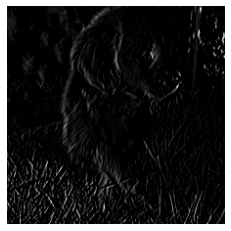

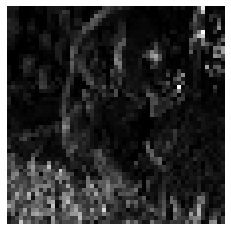

In [23]:
plt.imshow(output.squeeze().asnumpy(), cmap = 'gray')
plt.axis('off')
plt.show()
plt.imshow(pooled.squeeze().asnumpy(), cmap='gray')
o = plt.axis('off')
# This pooling layer has no parameters because it is dones't rely on any parameters and it is fully deterministic given the pool size and padding arguments.

## Dense Layer
- It performs matrix or dot multiplication of each input unit with a weights and adds bias to produce an output unit.
- The operation is repeated using possibly different weights and biases depending on the number of output units we need to produce.

we will look at the layer with three input units and ten output units. When a dense layer appears between other layers in the neural networks. Its output units are referred to as hidden units.

In [24]:
# When creating a dense layer, we define the number of output units and optionally input units. And we can also specify the activation function to apply once the output units are computed.
layer = nn.Dense(units = 10, in_units=3, activation='relu')
layer

Dense(3 -> 10, Activation(relu))

As an example, let's just initialize the weights with ones. Let's then create an empty array with a batch size of one, containing three input values corresponding to the input units arguments of the dense layer here.

In [27]:
layer.initialize(mx.init.One())

In [29]:
inputs = mx.nd.ones((1,3))
inputs, layer(inputs)

(
 [[1. 1. 1.]]
 <NDArray 1x3 @cpu(0)>,
 
 [[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
 <NDArray 1x10 @cpu(0)>)

In [30]:
layer.weight.data()


[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
<NDArray 10x3 @cpu(0)>